## Scan Context based odometry estimation

## 데이터 불러오기, 전처리

In [5]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pykitti
import sys

%matplotlib inline
np.random.seed(777)

sys.path.append('./src')

from kalman_filters import ExtendedKalmanFilter as EKF
from utils import lla_to_enu, normalize_angles

In [6]:
# Odometry Results
f = open("kitti_raw_20110930_0033.txt", 'r')
lines = f.readlines()
lines_f = [[float(i) for i in arr[:-1].split(" ")] for arr in lines]
lines_f = np.array(lines_f)

# kitti dataset
kitti_root_dir = '/datasets/kitti/raw'
kitti_date = '2011_09_30'
kitti_drive = '0033'
dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

In [7]:
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_forward_velocities = []  # [vehicle_forward_velocity(m/s),] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_forward_velocities.append(packet.vf)

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]

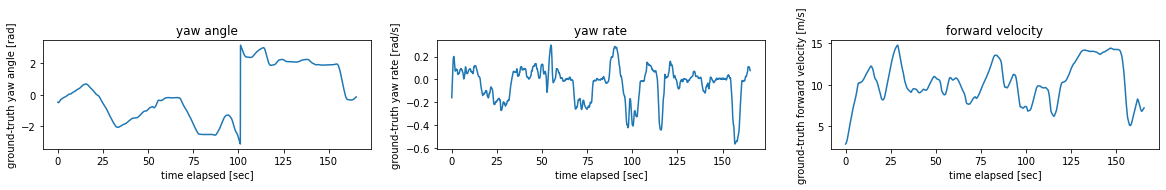

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20, 2))

ax[0].set_title("yaw angle")
ax[0].plot(ts, gt_yaws)
ax[0].set_xlabel('time elapsed [sec]')
ax[0].set_ylabel('ground-truth yaw angle [rad]')

ax[1].set_title("yaw rate")
ax[1].plot(ts, gt_yaw_rates)
ax[1].set_xlabel('time elapsed [sec]')
ax[1].set_ylabel('ground-truth yaw rate [rad/s]')

ax[2].set_title("forward velocity")
ax[2].plot(ts, gt_forward_velocities)
ax[2].set_xlabel('time elapsed [sec]')
ax[2].set_ylabel('ground-truth forward velocity [m/s]');

## Scan Context

### kitti LiDAR data

In [10]:
import os
import numpy as np
import pykitti
import time

np.random.seed(777)

kitti_root_dir = '/datasets/kitti/raw'
kitti_date = '2011_09_30'
kitti_drive = '0033'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

for idx, cloud in enumerate(dataset.velo):
#     makePointCloud2Msg(cloud[:, :3], idx, "KITTI", 'xyz')
    print(np.array(cloud[:,:3]).shape)
    print(idx)
    time.sleep(1)
    if idx == 2:
        break

(126997, 3)
0
(126939, 3)
1
(126807, 3)
2


### generate SCs

In [11]:
import numpy as np
np.set_printoptions(precision=4)
import time
from scipy import spatial

In [12]:
shape=[20,60]
num_candidates=10
threshold=0.15
max_length = 80 # recommended but other (e.g., 100m) is also ok.

ENOUGH_LARGE = 15000 # capable of up to ENOUGH_LARGE number of nodes 
ptclouds = [None] * ENOUGH_LARGE
scancontexts = [None] * ENOUGH_LARGE
ringkeys = [None] * ENOUGH_LARGE
curr_node_idx = 0


def ptcloud2sc(ptcloud, sc_shape, max_length):
    num_ring, num_sector = sc_shape

    gap_ring = max_length/num_ring
    gap_sector = 360/num_sector
    
    enough_large = 500
    sc_storage = np.zeros([enough_large, num_ring, num_sector])
    sc_counter = np.zeros([num_ring, num_sector])
    
    num_points = ptcloud.shape[0]
    
    def xy2theta(x, y):
        if (x >= 0 and y >= 0): 
            theta = 180/np.pi * np.arctan(y/x);
        if (x < 0 and y >= 0): 
            theta = 180 - ((180/np.pi) * np.arctan(y/(-x)));
        if (x < 0 and y < 0): 
            theta = 180 + ((180/np.pi) * np.arctan(y/x));
        if ( x >= 0 and y < 0):
            theta = 360 - ((180/np.pi) * np.arctan((-y)/x));
        return theta
    
    def pt2rs(point, gap_ring, gap_sector, num_ring, num_sector):
        x = point[0]
        y = point[1]
        # z = point[2]

        if(x == 0.0):
            x = 0.001
        if(y == 0.0):
            y = 0.001

        theta = xy2theta(x, y)
        faraway = np.sqrt(x*x + y*y)

        idx_ring = np.divmod(faraway, gap_ring)[0]       
        idx_sector = np.divmod(theta, gap_sector)[0]

        if(idx_ring >= num_ring):
            idx_ring = num_ring-1 # python starts with 0 and ends with N-1

        return int(idx_ring), int(idx_sector)
    
    
    for pt_idx in range(num_points):
        point = ptcloud[pt_idx, :]
        point_height = point[2] + 2.0 # for setting ground is roughly zero 
        
        idx_ring, idx_sector = pt2rs(point, gap_ring, gap_sector, num_ring, num_sector)
        
        if sc_counter[idx_ring, idx_sector] >= enough_large:
            continue
        sc_storage[int(sc_counter[idx_ring, idx_sector]), idx_ring, idx_sector] = point_height
        sc_counter[idx_ring, idx_sector] = sc_counter[idx_ring, idx_sector] + 1

    sc = np.amax(sc_storage, axis=0)
        
    return sc

In [13]:
def show_sc(cloud, ring_res, sector_res, max_length):
    N = len(sector_res)
    fig, ax = plt.subplots(1, N, figsize=(18, 4))
    for i in range(N):
        sc = ptcloud2sc(cloud, [ring_res[i], sector_res[i]], max_length)
        ax[i].imshow(sc)
    plt.show()

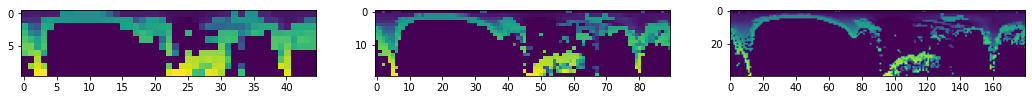

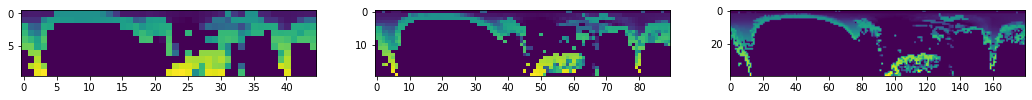

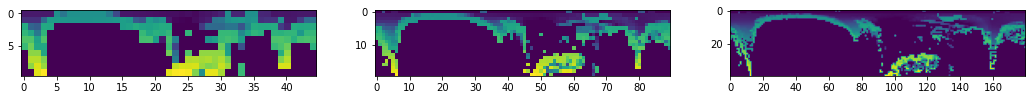

In [15]:
ring_res_multi = np.array([10, 20, 40])
sector_res_multi = np.array([45, 90, 180])

for idx, cloud in enumerate(dataset.velo):
    sample_cloud = np.array(cloud[:,:3])
    show_sc(sample_cloud, ring_res_multi, sector_res_multi, max_length)
    if idx == 2:
        break

### save SC

In [88]:
from tqdm import tqdm
shape=[40,180] # [ring, sector]
max_length = 80

scs = []

for idx, cloud in tqdm(enumerate(dataset.velo)):
    sc = ptcloud2sc(np.array(cloud[:,:3]), shape, max_length)
    scs.append(sc)
#     plt.imshow(sc)
#     plt.show()


0it [00:00, ?it/s]
1it [00:03,  3.23s/it]
2it [00:06,  3.22s/it]
3it [00:09,  3.23s/it]
4it [00:12,  3.23s/it]
5it [00:16,  3.24s/it]
6it [00:19,  3.26s/it]
7it [00:22,  3.27s/it]
8it [00:26,  3.29s/it]
9it [00:29,  3.29s/it]
10it [00:32,  3.29s/it]
11it [00:36,  3.31s/it]
12it [00:39,  3.31s/it]
13it [00:42,  3.30s/it]
14it [00:45,  3.30s/it]
15it [00:49,  3.30s/it]
16it [00:52,  3.28s/it]
17it [00:55,  3.29s/it]
18it [00:59,  3.29s/it]
19it [01:02,  3.27s/it]
20it [01:05,  3.28s/it]
21it [01:08,  3.29s/it]
22it [01:12,  3.31s/it]
23it [01:15,  3.30s/it]
24it [01:18,  3.31s/it]
25it [01:22,  3.30s/it]
26it [01:25,  3.30s/it]
27it [01:28,  3.31s/it]
28it [01:32,  3.32s/it]
29it [01:35,  3.34s/it]
30it [01:38,  3.35s/it]
31it [01:42,  3.34s/it]
32it [01:45,  3.34s/it]
33it [01:48,  3.35s/it]
34it [01:52,  3.34s/it]
35it [01:55,  3.36s/it]
36it [01:59,  3.35s/it]
37it [02:02,  3.34s/it]
38it [02:05,  3.33s/it]
39it [02:08,  3.34s/it]
40it [02:12,  3.34s/it]
41it [02:15,  3.34s/it]
42it 

588it [31:46,  3.28s/it]
589it [31:49,  3.28s/it]
590it [31:52,  3.29s/it]
591it [31:56,  3.29s/it]
592it [31:59,  3.27s/it]
593it [32:02,  3.26s/it]
594it [32:05,  3.24s/it]
595it [32:09,  3.24s/it]
596it [32:12,  3.23s/it]
597it [32:15,  3.24s/it]
598it [32:18,  3.24s/it]
599it [32:22,  3.23s/it]
600it [32:25,  3.20s/it]
601it [32:28,  3.19s/it]
602it [32:31,  3.18s/it]
603it [32:34,  3.16s/it]
604it [32:37,  3.14s/it]
605it [32:40,  3.14s/it]
606it [32:43,  3.14s/it]
607it [32:47,  3.12s/it]
608it [32:50,  3.13s/it]
609it [32:53,  3.13s/it]
610it [32:56,  3.14s/it]
611it [32:59,  3.14s/it]
612it [33:02,  3.16s/it]
613it [33:06,  3.17s/it]
614it [33:09,  3.18s/it]
615it [33:12,  3.20s/it]
616it [33:15,  3.21s/it]
617it [33:18,  3.22s/it]
618it [33:22,  3.24s/it]
619it [33:25,  3.25s/it]
620it [33:28,  3.26s/it]
621it [33:32,  3.27s/it]
622it [33:35,  3.27s/it]
623it [33:38,  3.27s/it]
624it [33:41,  3.26s/it]
625it [33:45,  3.27s/it]
626it [33:48,  3.29s/it]
627it [33:51,  3.29s/it]


1163it [1:02:57,  3.33s/it]
1164it [1:03:00,  3.34s/it]
1165it [1:03:04,  3.38s/it]
1166it [1:03:07,  3.37s/it]
1167it [1:03:10,  3.37s/it]
1168it [1:03:14,  3.34s/it]
1169it [1:03:17,  3.35s/it]
1170it [1:03:20,  3.33s/it]
1171it [1:03:24,  3.30s/it]
1172it [1:03:27,  3.29s/it]
1173it [1:03:30,  3.29s/it]
1174it [1:03:33,  3.25s/it]
1175it [1:03:37,  3.25s/it]
1176it [1:03:40,  3.23s/it]
1177it [1:03:43,  3.20s/it]
1178it [1:03:46,  3.18s/it]
1179it [1:03:49,  3.19s/it]
1180it [1:03:52,  3.16s/it]
1181it [1:03:55,  3.12s/it]
1182it [1:03:58,  3.09s/it]
1183it [1:04:01,  3.06s/it]
1184it [1:04:04,  3.01s/it]
1185it [1:04:07,  2.96s/it]
1186it [1:04:10,  2.89s/it]
1187it [1:04:13,  2.85s/it]
1188it [1:04:15,  2.82s/it]
1189it [1:04:18,  2.82s/it]
1190it [1:04:21,  2.84s/it]
1191it [1:04:24,  2.86s/it]
1192it [1:04:27,  2.91s/it]
1193it [1:04:30,  2.97s/it]
1194it [1:04:33,  3.03s/it]
1195it [1:04:36,  3.09s/it]
1196it [1:04:40,  3.13s/it]
1197it [1:04:43,  3.16s/it]
1198it [1:04:46,  3.

In [89]:
scs_ = np.array(scs)
print(scs_.shape)

(1594, 40, 180)


In [90]:
np.save('./experiments_sc/scs', scs_)

### load

In [16]:
scs = np.load('./experiments_sc/scs.npy')

In [17]:
scs.shape

(1594, 40, 180)

## Experiments

### train

In [1]:
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [18]:
print(gt_yaws.shape)
print(gt_forward_velocities.shape)

(1594,)
(1594,)


In [49]:
num_seq = 10
X_ = []
for idx in range(num_seq, len(scs)):
    seq = scs[idx].copy()
    for i in range(1, num_seq):
        seq = np.append(seq, scs[idx-i].copy())
    X_.append(seq)
X = np.array(X_)

In [69]:
times = np.array(ts)
labels = np.column_stack([gt_yaws.T, gt_forward_velocities.T])
print(labels.shape)

dataShape = X[0].shape
labelShape = labels[0].shape

(1594, 2)


In [70]:
num_seq = 10
X_ = scs.copy()[:,np.newaxis,:,:]
X = X_[num_seq:].copy()
for i in range(1, num_seq):
    X = np.concatenate((X, X_[num_seq-i:-i]), axis=1)
print(X.shape)

times = times[num_seq:]
labels = labels[num_seq:]

dataShape = X[0].shape
labelShape = labels[0].shape

(1584, 10, 40, 180)


In [71]:
labels, dataShape, labelShape

(array([[-0.4045,  3.5   ],
        [-0.3843,  3.6121],
        [-0.3648,  3.7264],
        ...,
        [-0.1594,  7.0774],
        [-0.1498,  7.125 ],
        [-0.1421,  7.1735]]),
 (10, 40, 180),
 (2,))

#### model

In [72]:
# Model 
from keras import backend as K
K.clear_session()

KernelSize = 5

inputs = keras.layers.Input(shape=(dataShape[0], dataShape[1], dataShape[2]))
x = keras.layers.Conv2D(filters=64, kernel_size=KernelSize, activation='relu', padding='same')(inputs)
x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=128, kernel_size=KernelSize, activation='relu', padding='same')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=KernelSize, activation='relu', padding='same')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(rate=0.7)(x)
x = keras.layers.Dense(units=64)(x)
x = keras.layers.Dropout(rate=0.7)(x)
outputs = keras.layers.Dense(units=labelShape[0], activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

ModuleNotFoundError: No module named 'tensorflow.python.keras.engine.base_layer_v1'

In [ ]:
# Model Compile 
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.build(None,)

#### train

In [ ]:
#Train
X_train = X[:500]
y_train = labels[:500]

nEpoch = 200

model.fit(X_train, y_train, epochs=nEpoch, batch_size=64, verbose=1)

In [ ]:
# model save 
modelName = 'experiments_sc/sc_odom_{}_{}.h5'.format(dataShape[1], dataShape[2])
model.save(modelName)

### inference

In [ ]:
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [ ]:
from keras.models import load_model
modelName = 'experiments_sc/sc_odom_{}_{}.h5'.format(dataShape[1], dataShape[2])
testModel = load_model(modelName)
testModel.summary()

In [ ]:
# Test
X_test = X[500:]
y_test = labels[500:]

In [ ]:
# Predict 
scores_TEST = testModel.evaluate(X_test, y_test, verbose=1, batch_size=1000)
print('- Test score:', scores_TEST[0])
print('- Test accuracy:', scores_TEST[1]*100)
print(' ')

In [ ]:
# save prediction (for later top N analysis )
y_predicted = testModel.predict(X_test)

# save 
filename_y_predicted = 'experiments_sc/predicts' + modelName
np.save(filename_y_predicted, y_seen_predicted)